So far, based on the data of math-related arXiv submissions—which we scraped and preprocessed in `Scarping and Cleaning the Data.ipynb`—we considered the text classification tasks of predicting the MSC classes and the primary arXiv category based on `cleaned_text` which is obtained from putting together the preprocessed title and abstract. (These are multi-label and multi-class tasks respectively). Support vector machines and convolutional neural networks were used in notebooks `MSC Prediction.ipynb` and `Math Archive Primary Category Prediction.ipynb` for these tasks respectively. Here, we play with the more advanced *transformer architecture* for the same classification problems, data, and train/test splits. We shall [implement transformers in the Keras API](https://keras.io/examples/nlp/text_classification_with_transformer). 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import gc

import keras
from keras import backend as K     # For Keras backend utilities.
from keras import ops              # For numpy operations. 
from keras import layers           

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import f1_score, accuracy_score, jaccard_score

We begin with classifying the primary arXiv category with transformers. Previously, in `Math Archive Primary Category Prediction.ipynb` we trained a convolutional neural net for this:

$\hspace{3cm}$  `cleaned_text`  $\mapsto$ the primary arXiv category (e.g. `math.AG`) $\hspace{1cm}$  (~30 labels).

We first load the data and the train/test split saved from before. 

In [2]:
data=pd.read_csv('data/data_encoded_CatPred.zip',compression='zip')

with open('data/train_index_CatPred.json','r') as file:
    train_index=json.load(file)
X_train=data.iloc[train_index]['cleaned_text']
y_train=data.iloc[train_index,1:]

with open('data/test_index_CatPred.json','r') as file:
    test_index=json.load(file)
X_test=data.iloc[test_index]['cleaned_text']
y_test=data.iloc[test_index,1:]

print(f'Number of training instances: {y_train.shape[0]}')
print(f'Number of test instances: {y_test.shape[0]}')
print(f'Number of the labels: {y_train.shape[1]}')

Number of training instances: 119381
Number of test instances: 39794
Number of the labels: 31


Implementing the positional embedding and the transformer block (including [Multi-Head Attention](https://keras.io/api/layers/attention_layers/multi_head_attention/), MLP, Add & Norm components):

In [3]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, input_dim, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=input_dim, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

We next tokenize and then pad the data with the same parameters used before for this text data (`maxlen=100` , `padding='post'`).

In [4]:
maxlen=100

tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train=tokenizer.texts_to_sequences(X_train)
X_train=pad_sequences(X_train, maxlen=maxlen, padding='post')

X_test=tokenizer.texts_to_sequences(X_test)
X_test=pad_sequences(X_test, maxlen=maxlen, padding='post')

# Saving the number of tokens 
vocabulary_size=len(tokenizer.word_counts)
print(f'Vocabulary size (based on the training set): {vocabulary_size}')

Vocabulary size (based on the training set): 71614


Below, we set up the transformer model. (Keras' Functional API is used instead of the Sequential API, [a comparison](https://medium.com/analytics-vidhya/keras-model-sequential-api-vs-functional-api-fc1439a6fb10).) Instead of a convolutional later, we include an attention block with two heads. Other architecture parameters are more or less the same as what used before for training a convolutional neural network for the same problem: the embedding layer outputs vectors of dimension 50; and a ReLU layer of size 200 is present. Dropout layers are used too (a higher drop out rate for more complex parts such as the attention block and the ReLU layer). 

In [5]:
embed_dim = 50            # Embedding size for each token
num_heads = 2             # Number of attention heads
ff_dim = 64               # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen=maxlen, input_dim=vocabulary_size+1, embed_dim=embed_dim)
x = embedding_layer(inputs)
x = layers.Dropout(0.1)(x)                                           
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim,rate=0.2)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(200, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(31, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 100, 50)        │     3,585,750 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 100, 50)        │        27,064 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 50)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 31)             │         6,231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,629,245 (13.84 MB)

 Trainable params: 3,629,245 (13.84 MB)

 Non-trainable params: 0 (0.00 B)

We use early stopping with patience, and we keep the best model. 

In [6]:
#Forming a dictionary for class weights: each class index will be associated with a number inversely proportional with its frequency.
#(All weights would be 1 if classes are completely balanced.)
#This causes the model to pay more attention to underrepresented labels.  
class_weight={}
for i in range(31):
    class_weight[i]=y_train.shape[0]/(y_train[y_train==i].shape[0])


#Early stopping: the training stops if validation loss does not decrease for two epochs. Furthermore, we keep the best model.
#https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, restore_best_weights=True)


opt=Adam(learning_rate=0.00005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])
history = model.fit(X_train, (y_train), 
                    batch_size=32, 
                    epochs=20, validation_split=0.3,class_weight=class_weight,
                    callbacks=[es])

Epoch 1/20
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 154s 56ms/step - accuracy: 0.1063 - loss: 3.2169 - val_accuracy: 0.4257 - val_loss: 2.0475
Epoch 2/20
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 82s 32ms/step - accuracy: 0.4420 - loss: 1.9563 - val_accuracy: 0.5537 - val_loss: 1.5326
Epoch 3/20
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 59s 23ms/step - accuracy: 0.5600 - loss: 1.5228 - val_accuracy: 0.6012 - val_loss: 1.3677
Epoch 4/20
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 61s 23ms/step - accuracy: 0.6158 - loss: 1.3220 - val_accuracy: 0.6256 - val_loss: 1.2866
Epoch 5/20
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 67s 26ms/step - accuracy: 0.6498 - loss: 1.1992 - val_accuracy: 0.6448 - val_loss: 1.2354
Epoch 6/20
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 75s 29ms/step - accuracy: 0.6790 - loss: 1.0942 - val_accuracy: 0.6523 - val_loss: 1.2087
Epoch 7/20
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 63s 24ms/step - accuracy: 0.7018 - loss: 1.0138 - val_accuracy: 0.6635 - val_loss: 1.1866
Epoch 8/20
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 63s 24ms/step - accuracy: 0.7216 

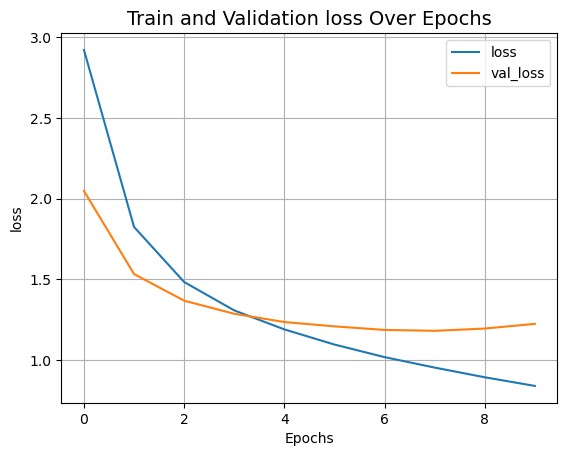

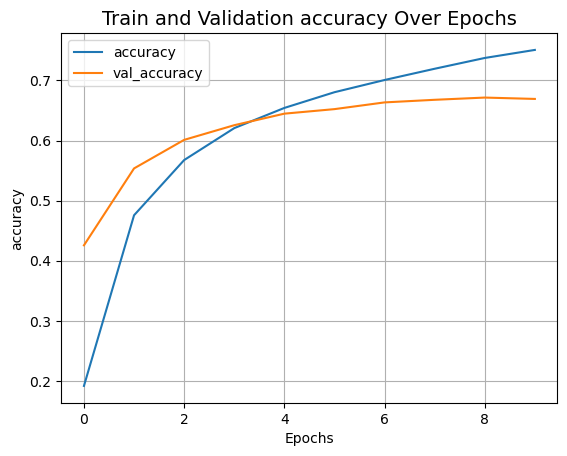

In [7]:
import matplotlib.pyplot as plt
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.locator_params(axis='x', integer=True)
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

We next evaluate the model. (Different [training APIs](https://keras.io/api/models/model_training_apis/): `compile` , `fit` , `evaluate` , `predict` etc.)

In [8]:
[test_loss,test_accuracy]=model.evaluate(X_test,y_test)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {round(100*test_accuracy,2)}%')

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6651 - loss: 1.1747
Test loss: 1.177572250366211
Test accuracy: 66.69%


Obtaining all relevant metrics on training and test sets:

In [9]:
#Consists of probabilities
y_pred_train_proba=model.predict(X_train)
y_pred_proba=model.predict(X_test) 


#Predicted labels based on predicted probabilities.
#https://stackoverflow.com/questions/20295046/numpy-change-max-in-each-row-to-1-all-other-numbers-to-0?rq=3
y_pred_train=(y_pred_train_proba==y_pred_train_proba.max(axis=1)[:,None]).astype(int)
y_pred=(y_pred_proba==y_pred_proba.max(axis=1)[:,None]).astype(int)


print('\nMetrics for predicting the primary arXiv category based on the cleaned text:\n')
print(f' Train Accuracy: {round(100*accuracy_score(y_train, y_pred_train, normalize=True),2)}%')
print(f" Train F1-score micro: {round(100*f1_score(y_train, y_pred_train, average='micro'),2)}%")
print(f" Train F1-score macro: {round(100*f1_score(y_train, y_pred_train, average='macro'),2)}%")
print(f" Train F1-score weighted: {round(100*f1_score(y_train, y_pred_train, average='weighted'),2)}%")



print(f' \n Test Accuracy:  {round(100*accuracy_score(y_test, y_pred, normalize=True),2)}%')
print(f" Test F1-score micro: {round(100*f1_score(y_test, y_pred, average='micro'),2)}%")
print(f" Test F1-score macro: {round(100*f1_score(y_test, y_pred, average='macro'),2)}%")
print(f" Test F1-score weighted: {round(100*f1_score(y_test, y_pred, average='weighted'),2)}%")  

3731/3731 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step

Metrics for predicting the primary arXiv category based on the cleaned text:

 Train Accuracy: 73.94%
 Train F1-score micro: 73.94%
 Train F1-score macro: 69.66%
 Train F1-score weighted: 73.48%
 
 Test Accuracy:  66.69%
 Test F1-score micro: 66.69%
 Test F1-score macro: 61.71%
 Test F1-score weighted: 66.12%


**Conclusion)** The performance of this transformer model on the test set is slightly better than what we obtained from training a CNN for the same problem of predicting the primary arXiv category. 

Saving this model:

In [10]:
# Caution: A .h5 file may be generated too. 
model.save('./models/clf_transformer.keras')

Next, we train a transformer for the multi-label problem of predicting 3-character MSC classes for which, previously, in `MSC Prediction.ipynb` we trained (and calibrated) a support vector machine:

$\hspace{3cm}$  `cleaned_text` $\mapsto$ 3-character MSC classes (e.g. 46L, 57M, 57R) $\hspace{1cm}$  (~500 labels).

First, we delete the current model and clearing the Keras session to avoid clutter from old models/layers.  

In [11]:
# https://stackoverflow.com/questions/50895110/what-do-i-need-k-clear-session-and-del-model-for-keras-with-tensorflow-gpu
# https://stackoverflow.com/questions/58137677/keras-model-training-memory-leak

del model            # Deleting the model. 
gc.collect()         # Clearing the remenant traces of the model with Python's garbage collection module. 
K.clear_session()    # Clearing the TensorFlow graph.

Next, we load the data and the train/validation/test split saved from before. 

In [12]:
data=pd.read_csv('data/data_encoded.zip',compression='zip')

with open('data/train_index.json','r') as file:
    train_index=json.load(file)
X_train=data.iloc[train_index]['cleaned_text']
y_train=data.iloc[train_index,1:]
    
with open('data/val_index.json','r') as file:
    val_index=json.load(file)
X_val=data.iloc[val_index]['cleaned_text']
y_val=data.iloc[val_index,1:]
    
with open('data/test_index.json','r') as file:
    test_index=json.load(file)
X_test=data.iloc[test_index]['cleaned_text']
y_test=data.iloc[test_index,1:]

print(f'Number of training instances: {y_train.shape[0]}')
print(f'Number of validation instances: {y_val.shape[0]}')
print(f'Number of test instances: {y_test.shape[0]}')
print(f'Number of labels: {y_test.shape[1]}')

Number of training instances: 104675
Number of validation instances: 18540
Number of test instances: 41015
Number of labels: 531


The training, validation and test sets were obtained from stratified sampling for multi-label data. We double check that the most common labels are distributed evenly between them. 

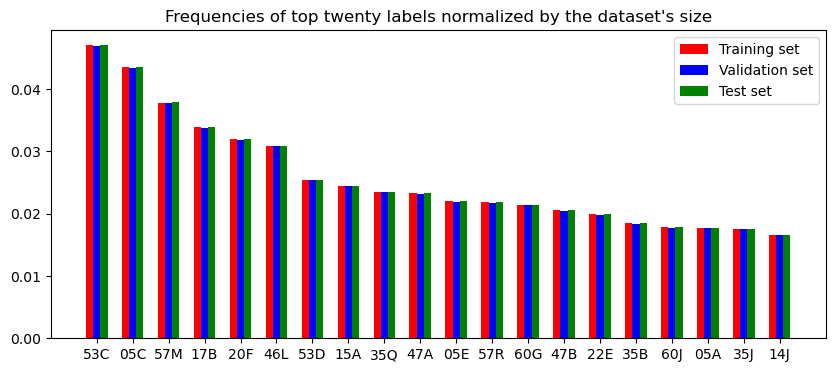

In [13]:
top_index=np.argsort(-np.asarray(data.iloc[:,1:].sum()))[:20]
top_MSC=data.columns[1:][top_index] 

ind=np.arange(20)
width=0.2

fig=plt.figure(figsize=(10,4))
ax=fig.add_subplot(111)
ax.bar(x=ind, height=y_train[top_MSC].sum(axis=0)/y_train.shape[0], width=width, color='r')
ax.bar(x=ind+width, height=y_val[top_MSC].sum(axis=0)/y_val.shape[0], width=width, color='b')
ax.bar(x=ind+2*width, height=y_test[top_MSC].sum(axis=0)/y_test.shape[0], width=width, color='g')
ax.set_xticks(ind+width)
ax.set_xticklabels(top_MSC)

ax.set_title("Frequencies of top twenty labels normalized by the dataset's size")
ax.legend(('Training set','Validation set','Test set'))

plt.show()

Tokenizing the data based on the new training set (with `maxlen=100` , `padding='post'` as before):

In [14]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train=tokenizer.texts_to_sequences(X_train)
X_train=pad_sequences(X_train, maxlen=maxlen, padding='post')

X_val=tokenizer.texts_to_sequences(X_val)
X_val=pad_sequences(X_val, maxlen=maxlen, padding='post')

X_test=tokenizer.texts_to_sequences(X_test)
X_test=pad_sequences(X_test, maxlen=maxlen, padding='post')

# Saving the number of tokens 
vocabulary_size=len(tokenizer.word_counts)
print(f'Vocabulary size (based on the training set): {vocabulary_size}')

Vocabulary size (based on the training set): 68006


Since the MSC prediction problem is more complex, we increase the embedding dimesnion, the number of attention heads, and their complexity. 

In [15]:
embed_dim = 64            # Embedding size for each token
num_heads = 4             # Number of attention heads
ff_dim = 128              # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen=maxlen, input_dim=vocabulary_size+1, embed_dim=embed_dim)
x = embedding_layer(inputs)
x = layers.Dropout(0.1)(x)                                           
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim,rate=0.2)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(200, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(531, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 100, 64)        │     4,358,848 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 100, 64)        │        83,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 531)            │       106,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,561,779 (17.40 MB)

 Trainable params: 4,561,779 (17.40 MB)

 Non-trainable params: 0 (0.00 B)

The task is multi-label, so we should use `sigmoid` activation in the last layer, and  `loss='binary_crossentropy'` in training (see [here](https://stackoverflow.com/questions/59336899/which-loss-function-and-metrics-to-use-for-multi-label-classification-with-very/59433454#59433454)). The validation set in hand will be used to evaluate loss for early stopping. Just like above, we set `patience=2` , `restore_best_weights=True`. 

In [16]:
es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, restore_best_weights=True)

opt=Adam(learning_rate=0.0001)
# Keras AUC metric: https://keras.io/api/metrics/classification_metrics/
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=[keras.metrics.AUC(multi_label=True,num_labels=531)])
history = model.fit(X_train, (y_train), 
                    batch_size=32, epochs=20, validation_data=(X_val, y_val),
                    callbacks=[es])

Epoch 1/20
3272/3272 ━━━━━━━━━━━━━━━━━━━━ 126s 38ms/step - auc: 0.4949 - loss: 0.0950 - val_auc: 0.5032 - val_loss: 0.0256
Epoch 2/20
3272/3272 ━━━━━━━━━━━━━━━━━━━━ 127s 33ms/step - auc: 0.5231 - loss: 0.0256 - val_auc: 0.6221 - val_loss: 0.0221
Epoch 3/20
3272/3272 ━━━━━━━━━━━━━━━━━━━━ 119s 36ms/step - auc: 0.6665 - loss: 0.0214 - val_auc: 0.7391 - val_loss: 0.0180
Epoch 4/20
3272/3272 ━━━━━━━━━━━━━━━━━━━━ 137s 42ms/step - auc: 0.7551 - loss: 0.0182 - val_auc: 0.7880 - val_loss: 0.0165
Epoch 5/20
3272/3272 ━━━━━━━━━━━━━━━━━━━━ 108s 33ms/step - auc: 0.7949 - loss: 0.0167 - val_auc: 0.8115 - val_loss: 0.0156
Epoch 6/20
3272/3272 ━━━━━━━━━━━━━━━━━━━━ 150s 46ms/step - auc: 0.8183 - loss: 0.0157 - val_auc: 0.8213 - val_loss: 0.0152
Epoch 7/20
3272/3272 ━━━━━━━━━━━━━━━━━━━━ 112s 34ms/step - auc: 0.8348 - loss: 0.0149 - val_auc: 0.8224 - val_loss: 0.0149
Epoch 8/20
3272/3272 ━━━━━━━━━━━━━━━━━━━━ 170s 52ms/step - auc: 0.8521 - loss: 0.0143 - val_auc: 0.8255 - val_loss: 0.0148
Epoch 9/20
3272/

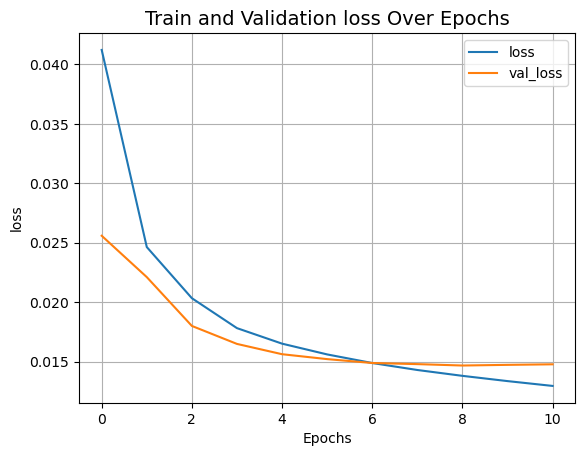

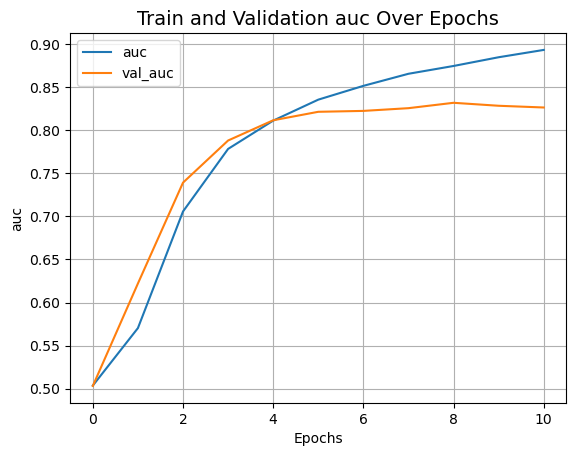

In [17]:
import matplotlib.pyplot as plt
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.locator_params(axis='x', integer=True)
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("auc")

The trained model outputs a probability for each of the 531 MSC classes. Since the problem is multi-label, they do not necessarily add up to 1, and for each of them a threshold must be picked. We use the validation set for thresholding. First, let's try a uniform threshold across labels: we pick a threshold that maximizes the accuracy over the validation set. For that threshold, over the test set, various metrics will be computed along with the $F_1$ scores for the binary classification problems corresponding to the most frequent labels. 

580/580 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step


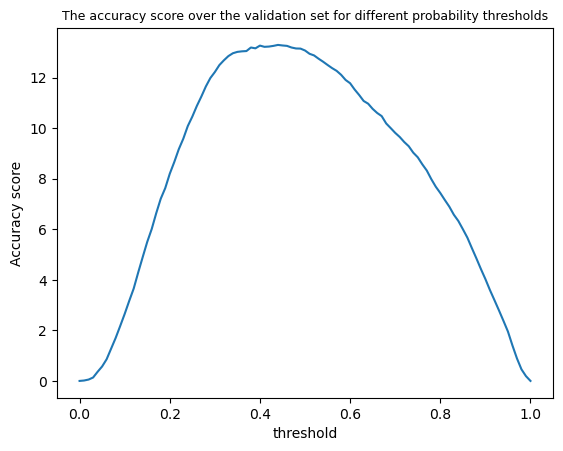

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step

Metrics for predicting 3-character MSC classes based on the cleaned text with the uniform thereshold 0.44:

 
 Test Accuracy:  13.19%
 Test F1-score micro: 35.88%
 Test F1-score macro: 12.84%
 Test F1-score weighted: 31.31%
 Test average Jaccard score: 28.58%

Test F1-scores for the top twenty most frequent labels:
 [64.29, 68.2, 64.2, 65.26, 55.9, 63.95, 63.65, 43.81, 52.94, 46.6, 38.05, 40.06, 43.74, 45.34, 40.32, 31.26, 48.03, 45.65, 37.76, 49.43]


In [18]:
y_pred_val_proba=model.predict(X_val)
thresholds=np.linspace(0,1,101)
scores=np.zeros(101)

for i in range(101):
    scores[i]=100*accuracy_score(y_val, (y_pred_val_proba>thresholds[i]).astype(int))
    
plt.plot(thresholds,scores)
plt.xlabel('threshold')
plt.ylabel('Accuracy score')
plt.title('The accuracy score over the validation set for different probability thresholds', fontsize=9)
plt.show()

threshold=thresholds[np.argmax(scores)]
y_pred_proba=model.predict(X_test)
y_pred=(y_pred_proba>threshold).astype(int)

print(f'\nMetrics for predicting 3-character MSC classes based on the cleaned text with the uniform thereshold {threshold}:\n')
print(f' \n Test Accuracy:  {round(100*accuracy_score(y_test, y_pred, normalize=True),2)}%')
print(f" Test F1-score micro: {round(100*f1_score(y_test, y_pred, average='micro'),2)}%")
print(f" Test F1-score macro: {round(100*f1_score(y_test, y_pred, average='macro'),2)}%")
print(f" Test F1-score weighted: {round(100*f1_score(y_test, y_pred, average='weighted'),2)}%") 
print(f" Test average Jaccard score: {round(100*jaccard_score(y_test, y_pred, average='samples'),2)}%") 

list_top_f1=[]
MSC_list=y_val.columns.to_list()
for top_class in top_MSC:
    column_index=MSC_list.index(top_class)
    list_top_f1+=[round(100*f1_score(y_test[top_class],y_pred[:,column_index]),2)]
    
print(f'\nTest F1-scores for the top twenty most frequent labels:\n {list_top_f1}')

It is also possible to choose thresholds separately. Meaning, for each label, we pick a threshold that maximizes the accuracy of the corresponding binary classifier. This can be done in a highly-vectorized fashion. 

In [19]:
def varying_thresholds(y_true,y_proba,n=100):
    """
    For a multi-label classification problem, returns thresholds that maximize the accuracy of prediction for every label.  
    
    Input
    -----
    y_true: numpy array
        The array of true labels, of shape data_size*(n_labels).
    y_proba: numpy array
        The array of predicted labels, of shape data_size*(n_labels).
    n: int
         Determines the thresholds to be examined, n+1 thresholds obtained from dividing [0,1] into n subintervals of length 1/n.
         
    Output
    ------
    A numpy array of thresholds, one for each label. 
    """
    assert isinstance(y_true,np.ndarray) and isinstance(y_proba,np.ndarray), "[Error] The first two inputs should be numpy arrays."
    assert y_true.ndim==2 and y_true.shape==y_proba.shape, "[Error] The input arrays should be 2D and with the same shape."
    assert isinstance(n,int) and n>0, "[Error] The last (optional) input should a positive integer."
     
    thresholds=np.linspace(0,1,n+1)          
    #A syntax for repeating an array a number of times along a new dimension:
    thresholds_array=np.repeat(thresholds[None,:],y_true.shape[0],axis=0)        #size: data_size*(n+1)            
    y_proba_duplicated=np.repeat(y_proba[:,None,:],n+1,axis=1)                   #size: data_size*(n+1)*(n_labels)
    y_pred_labels=(y_proba_duplicated>thresholds_array[:,:,None]).astype(int)    #size: data_size*(n+1)*(n_labels)
    y_true_duplicated=np.repeat(y_true[:,None,:],n+1,axis=1)                     #size: data_size*(n+1)*(n_labels)
    accuracy_array=np.sum((y_pred_labels==y_true_duplicated).astype(int),axis=0) #size: (n+1)*(n_labels)
    best_thresholds_index=np.argmax(accuracy_array,axis=0)                       #size: n_labels
    return thresholds[best_thresholds_index]
    
    
thresholds=varying_thresholds(np.asarray(y_val),y_pred_val_proba)
print(f'Different probability thresholds chosen for different labels:\n {thresholds}\n')

y_pred=(y_pred_proba>thresholds[None,:]).astype(int)

print('Metrics for predicting 3-character MSC classes based on the cleaned text with varying thresholds:\n')
print(f' \n Test Accuracy:  {round(100*accuracy_score(y_test, y_pred, normalize=True),2)}%')
print(f" Test F1-score micro: {round(100*f1_score(y_test, y_pred, average='micro'),2)}%")
print(f" Test F1-score macro: {round(100*f1_score(y_test, y_pred, average='macro'),2)}%")
print(f" Test F1-score weighted: {round(100*f1_score(y_test, y_pred, average='weighted'),2)}%") 
print(f" Test average Jaccard score: {round(100*jaccard_score(y_test, y_pred, average='samples'),2)}%") 

list_top_f1=[]
for top_class in top_MSC:
    column_index=MSC_list.index(top_class)
    list_top_f1+=[round(100*f1_score(y_test[top_class],y_pred[:,column_index]),2)]
    
print(f'\nTest F1-scores for the top twenty most frequent labels:\n {list_top_f1}')

Different probability thresholds chosen for different labels:
 [0.49 0.03 0.08 0.5  0.19 0.06 0.31 0.35 0.54 0.49 0.48 0.12 0.06 0.61
 0.08 0.17 0.62 0.24 0.04 0.76 0.11 0.53 0.15 0.56 0.5  0.47 0.05 0.38
 0.58 0.42 0.64 0.62 0.43 0.38 0.6  0.02 0.01 0.17 0.32 0.09 0.19 0.41
 0.79 0.49 0.28 0.01 0.03 0.45 0.6  0.21 0.2  0.05 0.35 0.21 0.64 0.27
 0.59 0.02 0.09 0.46 0.72 0.02 0.01 0.04 0.12 0.48 0.64 0.39 0.43 0.1
 0.03 0.47 0.03 0.24 0.31 0.37 0.58 0.02 0.01 0.27 0.13 0.02 0.26 0.35
 0.35 0.12 0.45 0.54 0.06 0.2  0.22 0.42 0.27 0.43 0.37 0.09 0.2  0.55
 0.65 0.6  0.13 0.35 0.01 0.67 0.6  0.49 0.06 0.37 0.19 0.26 0.37 0.5
 0.71 0.43 0.38 0.17 0.3  0.4  0.02 0.19 0.15 0.06 0.6  0.59 0.24 0.52
 0.07 0.38 0.24 0.45 0.39 0.51 0.18 0.34 0.51 0.44 0.47 0.31 0.24 0.62
 0.1  0.23 0.11 0.35 0.49 0.26 0.03 0.43 0.16 0.09 0.06 0.47 0.34 0.37
 0.3  0.66 0.54 0.05 0.02 0.45 0.48 0.14 0.72 0.4  0.05 0.05 0.19 0.01
 0.19 0.04 0.58 0.01 0.31 0.03 0.48 0.01 0.3  0.6  0.03 0.06 0.5  0.4
 0.09 0.1  0.12 0

**Conclusion)** With either of the two thresholding conventions above, the performance over the test set of the transformer model is worse than that of the SVM model we had trained before (slightly better accuracy but other metrics are far worse). Therefore, on our data, SVM seems to work better than transformers for predicting Mathematical Subject Classes. 

A useful link

----------------------------------------------------------------------------------------

[A curated list of learning resources on transformers and LLMs, carefully divided to different topics.](https://drive.google.com/file/d/13a74b1w1Ecb9ZHvPvrFpQfAH1U2dUERh/view?usp=sharing)